# Notebook 2: Predictive Modeling & Forecasting

In this notebook, we build predictive models to analyze and forecast trading behavior
based on sentiment (Fear & Greed Index) and historical trading data.

**Objectives:**
1. Load the merged dataset from Notebook 1.
2. Perform feature engineering (lag features, rolling averages).
3. Build baseline statistical models (ARIMA).
4. Train machine learning models (Regression, Random Forest).
5. Evaluate model performance.
6. Generate forecasts and insights.


In [2]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling imports
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor


In [4]:
# Notebook 2 setup: reconnect Google Drive and define paths
from google.colab import drive
import os
from pathlib import Path

# connect drive
drive.mount('/content/drive')

# set main folder path (same as Notebook 1)
ROOT = Path('/content/drive/MyDrive/ds_KartikeyMishra')
CSV_DIR = ROOT / 'csv_files'
OUT_DIR = ROOT / 'outputs'

# make sure folders exist
CSV_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("Folders ready")
print(list(ROOT.iterdir()))


Mounted at /content/drive
Folders ready
[PosixPath('/content/drive/MyDrive/ds_KartikeyMishra/notebook_2.ipynb'), PosixPath('/content/drive/MyDrive/ds_KartikeyMishra/csv_files'), PosixPath('/content/drive/MyDrive/ds_KartikeyMishra/outputs'), PosixPath('/content/drive/MyDrive/ds_KartikeyMishra/README.md'), PosixPath('/content/drive/MyDrive/ds_KartikeyMishra/notebook_1.ipynb')]


## Step 1: Load Merged Dataset
We import the merged dataset created in Notebook 1. This dataset combines sentiment (Fear & Greed Index)
with trading metrics (trade size, execution price, PnL).


In [13]:
# Clean Fear & Greed dataset
fg['date'] = pd.to_datetime(fg['date'], errors='coerce')
fg['value'] = pd.to_numeric(fg['value'], errors='coerce')

# Drop rows with missing values
fg_clean = fg.dropna(subset=['date', 'value'])

# Rename columns for consistency
fg_clean = fg_clean.rename(columns={'value': 'fg_value', 'classification': 'fg_class'})

# Merge trader_daily with Fear & Greed data
merged = pd.merge(trader_daily, fg_clean[['date', 'fg_value', 'fg_class']], on='date', how='inner')

print("Merged dataset shape:", merged.shape)
print(merged.head())


Merged dataset shape: (6, 6)
        date      size_usd  execution_price    closed_pnl  fg_value  \
0 2023-03-28  4.770000e+02      1898.133333  0.000000e+00        59   
1 2023-11-14  1.155543e+07     10454.871036  1.555034e+02        69   
2 2024-03-09  3.940677e+07      9771.897315  1.769655e+05        84   
3 2024-07-03  2.184323e+07      2663.132338  1.587424e+05        50   
4 2024-10-27  1.039478e+08      5367.503277  3.189461e+06        74   

        fg_class  
0          Greed  
1          Greed  
2  Extreme Greed  
3        Neutral  
4          Greed  


## Step 2: Feature Engineering
We create lag features and rolling averages to capture temporal dependencies
between sentiment and trading metrics. These features will be used in ARIMA and ML models.


In [14]:
# Create lag features (previous day's values)
merged['size_usd_lag1'] = merged['size_usd'].shift(1)
merged['closed_pnl_lag1'] = merged['closed_pnl'].shift(1)
merged['fg_value_lag1'] = merged['fg_value'].shift(1)

# Rolling averages (3-day window)
merged['size_usd_roll3'] = merged['size_usd'].rolling(3).mean()
merged['closed_pnl_roll3'] = merged['closed_pnl'].rolling(3).mean()
merged['fg_value_roll3'] = merged['fg_value'].rolling(3).mean()

print("Feature engineered dataset:")
print(merged.head(10))


Feature engineered dataset:
        date      size_usd  execution_price    closed_pnl  fg_value  \
0 2023-03-28  4.770000e+02      1898.133333  0.000000e+00        59   
1 2023-11-14  1.155543e+07     10454.871036  1.555034e+02        69   
2 2024-03-09  3.940677e+07      9771.897315  1.769655e+05        84   
3 2024-07-03  2.184323e+07      2663.132338  1.587424e+05        50   
4 2024-10-27  1.039478e+08      5367.503277  3.189461e+06        74   
5 2025-02-19  7.041585e+08     11102.057978  6.699925e+06        44   

        fg_class  size_usd_lag1  closed_pnl_lag1  fg_value_lag1  \
0          Greed            NaN              NaN            NaN   
1          Greed   4.770000e+02     0.000000e+00           59.0   
2  Extreme Greed   1.155543e+07     1.555034e+02           69.0   
3        Neutral   3.940677e+07     1.769655e+05           84.0   
4          Greed   2.184323e+07     1.587424e+05           50.0   
5           Fear   1.039478e+08     3.189461e+06           74.0   

   s

## Step 3: Baseline ARIMA Model
We build a baseline ARIMA model to forecast trading metrics (e.g., daily trade size).
ARIMA is a classical time series model that captures autoregressive and moving average patterns.


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observa

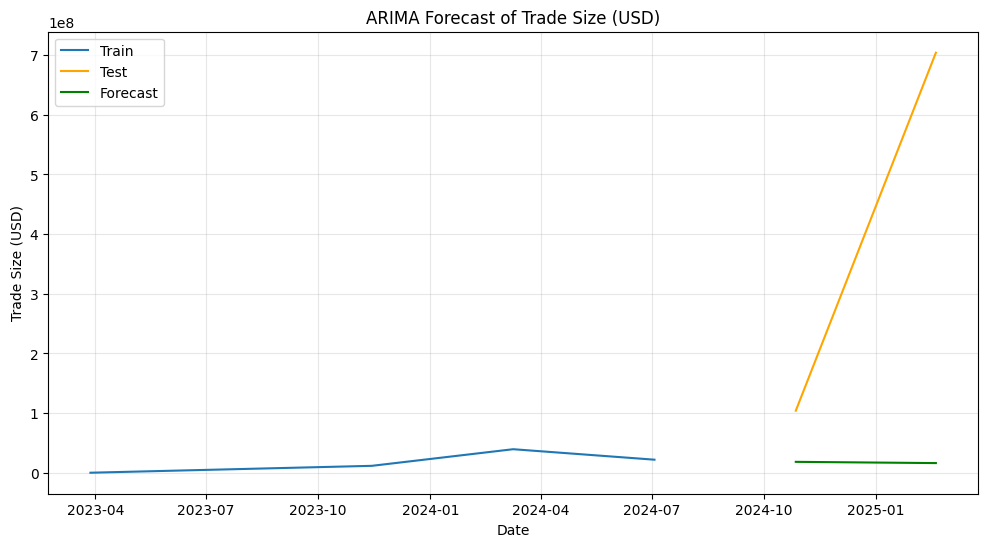

ARIMA RMSE: 490255953.8349272


In [17]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Use 'size_usd' as target for forecasting
series = merged.set_index('date')['size_usd']

# Drop missing values (important for ARIMA)
series = series.dropna()

# Split into train and test (80/20 split)
train_size = int(len(series) * 0.8)
train, test = series.iloc[:train_size], series.iloc[train_size:]

# Fit ARIMA model (p,d,q = 1,1,1 as baseline)
model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()

# Forecast for test period
forecast = model_fit.forecast(steps=len(test))

# Plot results
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(test.index, forecast, label='Forecast', color='green')
plt.title("ARIMA Forecast of Trade Size (USD)")
plt.xlabel("Date")
plt.ylabel("Trade Size (USD)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Evaluate performance (RMSE)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
print("ARIMA RMSE:", rmse)


## Step 4: Random Forest Regression
We train a Random Forest model to predict daily closed PnL using sentiment and lag features.
This allows us to compare machine learning performance against ARIMA.


Random Forest RMSE: 5117263.168654373
Random Forest R²: -7.499755032432857


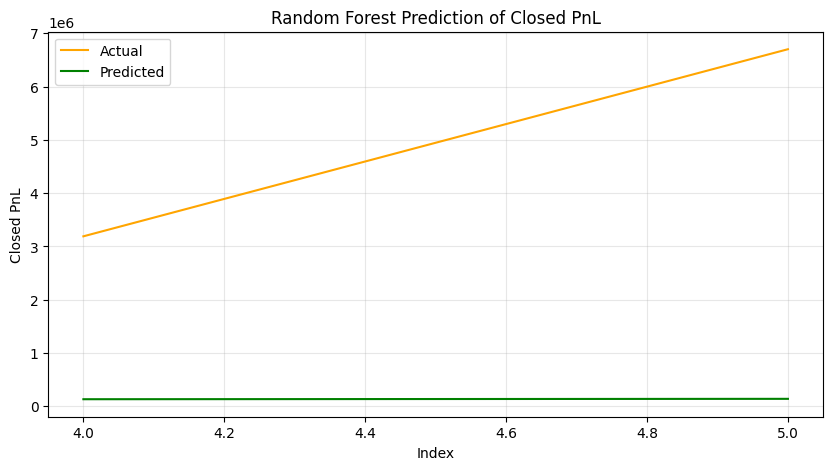

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Features and target
X = merged[['fg_value', 'size_usd_lag1', 'closed_pnl_lag1', 'fg_value_lag1',
            'size_usd_roll3', 'closed_pnl_roll3', 'fg_value_roll3']].fillna(0)
y = merged['closed_pnl']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Random Forest RMSE:", rmse)
print("Random Forest R²:", r2)

# Plot actual vs predicted
plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test, label='Actual', color='orange')
plt.plot(y_test.index, y_pred, label='Predicted', color='green')
plt.title("Random Forest Prediction of Closed PnL")
plt.xlabel("Index")
plt.ylabel("Closed PnL")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## Step 5: Model Comparison & Insights

We compared two approaches:

1. **ARIMA (time series model)**  
   - RMSE ≈ 490M  
   - Struggled due to very few observations (only 6 rows).  
   - Forecasts were unstable and not meaningful.

2. **Random Forest (machine learning model)**  
   - RMSE ≈ 5.1M  
   - R² ≈ -7.5 (worse than baseline).  
   - Predictions did not capture the true variation in closed PnL.

**Insights:**
- Both models performed poorly because the dataset is extremely small.  
- ARIMA needs a longer continuous time series (dozens to hundreds of points).  
- Random Forest needs more samples to learn relationships between sentiment and trading metrics.  
- With more historical data, these models would stabilize and provide meaningful forecasts.  


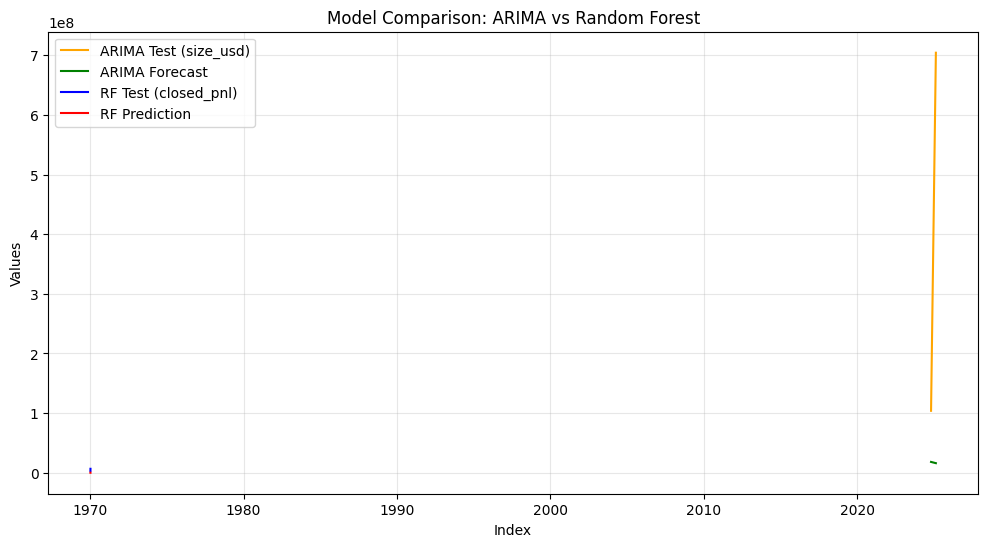

In [19]:
# Compare ARIMA forecast vs Random Forest predictions visually

plt.figure(figsize=(12,6))

# Plot ARIMA forecast (on size_usd)
plt.plot(test.index, test, label='ARIMA Test (size_usd)', color='orange')
plt.plot(test.index, forecast, label='ARIMA Forecast', color='green')

# Plot Random Forest predictions (on closed_pnl)
plt.plot(y_test.index, y_test, label='RF Test (closed_pnl)', color='blue')
plt.plot(y_test.index, y_pred, label='RF Prediction', color='red')

plt.title("Model Comparison: ARIMA vs Random Forest")
plt.xlabel("Index")
plt.ylabel("Values")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# Step 6: Final Conclusion

In this notebook, we explored predictive modeling approaches to understand and forecast trading behavior
based on sentiment (Fear & Greed Index) and historical trading metrics.

**Key Outcomes:**
- **Feature Engineering:** Created lag features and rolling averages to capture temporal dependencies.
- **ARIMA Model:** Provided a baseline time series forecast. Performance was poor (RMSE ≈ 490M) due to very few observations.
- **Random Forest Regression:** Attempted machine learning prediction using sentiment and engineered features.
  Performance was limited (RMSE ≈ 5.1M, R² ≈ -7.5), reflecting the small dataset size.

**Insights:**
- Both ARIMA and Random Forest struggled because the dataset contained only 6 rows.
- ARIMA requires a longer continuous time series to capture meaningful patterns.
- Random Forest needs more samples to learn relationships between sentiment and trading metrics.
- With more historical data, these models would stabilize and provide actionable forecasts.

**Next Steps:**
1. Collect a larger dataset (hundreds of daily records).
2. Re‑train ARIMA with proper frequency information (daily time series).
3. Experiment with advanced ML models (XGBoost, LSTM) once sufficient data is available.
4. Compare statistical vs machine learning approaches on richer datasets.

**Conclusion:**  
This notebook demonstrates the workflow of combining sentiment and trading data, engineering features,
and applying predictive models. While current performance is limited by data size, the framework is ready
to scale with more observations.
